In [1]:
import scanpy as sc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns

In [2]:
go_path = "../../data/Data_GEARS/adamson/go.csv"
gene_path = "../../data/Data_GEARS/essential_all_data_pert_genes.pkl"
df = pd.read_csv(go_path)
df = df.groupby("target").apply(lambda x: x.nlargest(20 + 1, ["importance"])).reset_index(drop=True)
with open(gene_path, "rb") as f:
    gene_list = pickle.load(f)
df = df[df["source"].isin(gene_list)]

def get_map(pert):
    tmp = pd.DataFrame(np.zeros(len(gene_list)), index=gene_list)
    tmp.loc[df[df.target == pert].source.values, :] = df[df.target == pert].importance.values[:, np.newaxis]
    return tmp.values.flatten()
def reorder_dataframe(df):
    row_linkage = linkage(df, method="ward")
    col_linkage = linkage(df.T, method="ward")
    row_order = dendrogram(row_linkage, no_plot=True)["leaves"]
    col_order = dendrogram(col_linkage, no_plot=True)["leaves"]
    return df.iloc[row_order, :].iloc[:, col_order]

/var/folders/mv/8qq6_6n90m9cbkrpl5_cwft40000gn/T/ipykernel_13654/3193877132.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("target").apply(lambda x: x.nlargest(20 + 1, ["importance"])).reset_index(drop=True)


In [3]:
adata = sc.read('../../data/Data_GEARS/adamson/perturb_processed.h5ad')
adata.obs["perturbation"] = [cond.split("+")[0] for cond in adata.obs["condition"]]
adata.obs["perturbation"] = adata.obs["perturbation"].astype("category")
pert2neighbor =  {i: get_map(i) for i in list(adata.obs["perturbation"].cat.categories)}

go_term = pd.DataFrame(pert2neighbor, index=gene_list).T
filter_go = go_term.loc[:, (go_term.sum(axis=0) > 0)]
filter_go = filter_go.drop(index="ctrl")

binary_go = filter_go > 0
binary_go_ordered = reorder_dataframe(binary_go)

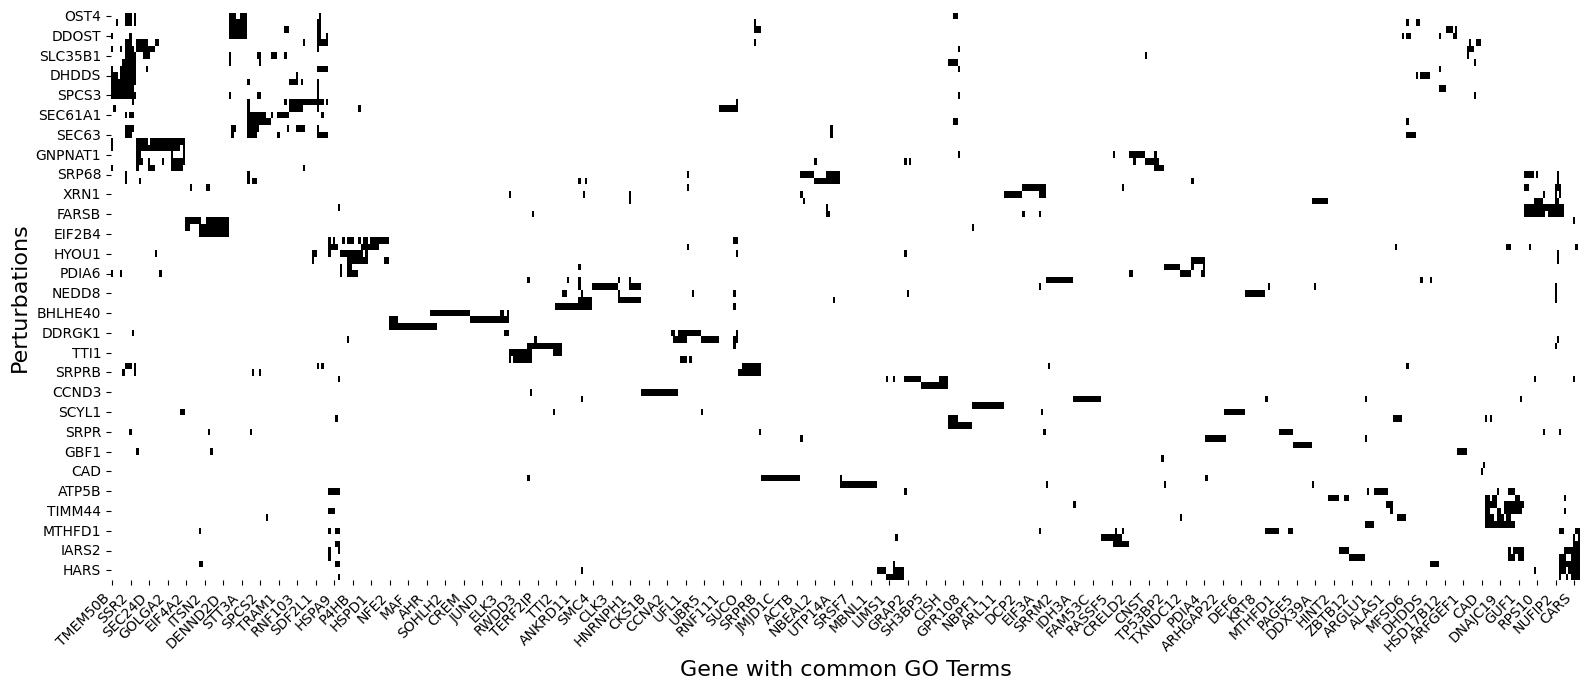

In [4]:
plt.figure(figsize=(16, 7))
sns.heatmap(binary_go_ordered, cmap=['white', 'black'], cbar=False)
plt.xlabel('Gene with common GO Terms', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Perturbations', fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
avg_overlaps = []
for i in range(binary_go.shape[0]):
    row = binary_go.iloc[i]
    overlaps = (binary_go & row).sum(axis=1)
    average_overlap = overlaps.drop(binary_go.index[i]).mean()
    avg_overlaps.append(average_overlap)
    print(f"Average overlap for row {i}: {average_overlap}")
print(f"Average overlap: {np.mean(avg_overlaps)}")

Average overlap for row 0: 0.8352941176470589
Average overlap for row 1: 0.0
Average overlap for row 2: 0.07058823529411765
Average overlap for row 3: 0.3176470588235294
Average overlap for row 4: 0.5647058823529412
Average overlap for row 5: 0.08235294117647059
Average overlap for row 6: 0.0
Average overlap for row 7: 0.27058823529411763
Average overlap for row 8: 0.08235294117647059
Average overlap for row 9: 0.4
Average overlap for row 10: 0.6235294117647059
Average overlap for row 11: 0.5882352941176471
Average overlap for row 12: 0.10588235294117647
Average overlap for row 13: 0.7411764705882353
Average overlap for row 14: 0.8
Average overlap for row 15: 0.08235294117647059
Average overlap for row 16: 1.0235294117647058
Average overlap for row 17: 0.4
Average overlap for row 18: 0.9058823529411765
Average overlap for row 19: 1.188235294117647
Average overlap for row 20: 0.43529411764705883
Average overlap for row 21: 0.4588235294117647
Average overlap for row 22: 0.4
Average overl